In [132]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold,GridSearchCV
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [133]:
data=pd.read_csv('/content/Main_data.csv')

In [134]:
data=data.drop('Unnamed: 0',axis=1)

In [135]:
data.head()

,Country,Year,GDP_P,PPP,GDP_C,Export,INFL,Invest,Import,FER,Topic-1,Topic-2,Topic-3
0,USA,1981,7.910,1.497000,194.804722,NaN,2.500000,35.476,NaN,1.498386,0.314124,0.249755,0.436120
1,USA,1982,5.281,3.664000,266.577848,1.423,11.346060,19.169,14.044,7.862945,0.289572,0.061015,0.649412
2,USA,1983,3.181,243.360647,9465.379714,8.834,7.778582,33.912,-16.650,226.740833,0.225028,0.183148,0.591824
3,USA,1984,-2.028,0.507410,10032.062100,0.927,17.965930,19.030,-5.344,0.430295,0.270568,0.333333,0.396099
4,USA,1985,5.110,2.019661,18832.196720,6.969,4.022499,32.129,8.905,1.675708,0.299037,0.252532,0.448431


In [136]:
#Checking for null values

data.isnull().sum()

Country     0
Year        0
GDP_P       0
PPP         0
GDP_C       2
Export     18
INFL        0
Invest      0
Import     18
FER         0
Topic-1     0
Topic-2     0
Topic-3     0
dtype: int64

In [137]:
#Replacing null values

data['GDP_C'].fillna((data['GDP_C'].median()), inplace=True)
data['Export'].fillna((data['Export'].mean()), inplace=True)
data['Import'].fillna((data['Import'].mean()), inplace=True)

In [138]:
#Handling outliers 

for i in data.columns:
    if data[i].dtype!='object':
        q1 = data[i].quantile(.25)
        q3 = data[i].quantile(.75)
        IQR = q3 - q1
        data[i]= np.clip(data[i], q1 - 1.5 *IQR, q3 + 1.5 * IQR)

In [139]:
#As we know our Numerical data is not normal so we are normalising it here

from sklearn import preprocessing

x=data.iloc[:,2:]

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled,columns=x.columns)

In [140]:
data['GDP_P']=x_scaled['GDP_P']
data['PPP']=x_scaled['PPP']
data['GDP_C']=x_scaled['GDP_C']
data['Export']=x_scaled['Export']
data['INFL']=x_scaled['INFL']
data['Invest']=x_scaled['Invest']
data['Import']=x_scaled['Import']
data['FER']=x_scaled['FER']
data['Topic-1']=x_scaled['Topic-1']
data['Topic-2']=x_scaled['Topic-2']
data['Topic-3']=x_scaled['Topic-3']

In [141]:
data=data.sort_values('Year')
data=data.reset_index()
data=data.drop('index',axis=1)

In [142]:
X=data.drop(['FER','Country'],axis=1)
Y=data['FER']

In [143]:
#Segregating Numeric data

numeric=[]
for i in data.columns:
  if data[i].dtype=='float':
    numeric.append(i)

In [144]:
df=data.loc[:,numeric]
df

,GDP_P,PPP,GDP_C,Export,INFL,Invest,Import,FER,Topic-1,Topic-2,Topic-3
0,0.858979,0.234866,0.000000,0.509482,0.279029,0.820841,0.506675,0.078495,0.577072,0.467969,0.54108
1,0.297461,0.195800,0.490817,0.430613,0.180670,0.366178,0.340423,0.066991,0.577072,0.467969,0.54108
2,0.484815,0.305068,0.184813,0.986607,0.309896,0.484301,0.520324,0.123092,0.577072,0.467969,0.54108
3,0.252975,1.000000,0.363798,0.590121,0.034092,0.397771,0.333030,1.000000,0.577072,0.467969,0.54108
4,0.508147,0.103942,0.057664,0.655694,0.595742,0.129345,0.870056,0.056472,0.577072,0.467969,0.54108
...,...,...,...,...,...,...,...,...,...,...,...
346,0.955184,0.419659,0.010810,1.000000,0.042927,0.876637,0.973290,0.433601,0.000000,0.000000,0.00000
347,0.426485,0.108626,0.507491,0.543188,0.128782,0.107058,0.463643,0.034289,0.000000,0.000000,0.00000
348,0.593930,1.000000,0.122307,0.862930,0.261973,0.605122,0.683664,1.000000,0.000000,0.000000,0.00000
349,0.576664,0.188419,0.245230,0.620175,0.216155,0.263343,0.832459,0.072534,0.000000,0.000000,0.00000


In [145]:
#Transforming data beacause data is not linear

trans=df.transform([np.sqrt])

#adding Year and Country into transform data

trans['Years']=data['Year']
trans['Country']=data['Country']

In [146]:
trans.isnull().sum()

GDP_P    sqrt    0
PPP      sqrt    0
GDP_C    sqrt    0
Export   sqrt    0
INFL     sqrt    0
Invest   sqrt    0
Import   sqrt    0
FER      sqrt    0
Topic-1  sqrt    0
Topic-2  sqrt    0
Topic-3  sqrt    0
Years            0
Country          0
dtype: int64

In [147]:
trans.columns

MultiIndex([(  'GDP_P', 'sqrt'),
            (    'PPP', 'sqrt'),
            (  'GDP_C', 'sqrt'),
            ( 'Export', 'sqrt'),
            (   'INFL', 'sqrt'),
            ( 'Invest', 'sqrt'),
            ( 'Import', 'sqrt'),
            (    'FER', 'sqrt'),
            ('Topic-1', 'sqrt'),
            ('Topic-2', 'sqrt'),
            ('Topic-3', 'sqrt'),
            (  'Years',     ''),
            ('Country',     '')],
           )

In [148]:
Y=trans['FER']
X=trans.drop(['FER'],axis=1)

In [149]:
#Renaming the columns

new_col=[]
for i in range(len(X.columns)):
  new_col.append(X.columns[i][0])

#reseting columns

X=X.set_axis(new_col, axis=1, inplace=False)

In [150]:
X.columns

Index(['GDP_P', 'PPP', 'GDP_C', 'Export', 'INFL', 'Invest', 'Import',
       'Topic-1', 'Topic-2', 'Topic-3', 'Years', 'Country'],
      dtype='object')

In [151]:
#Converting categorical to the numerical

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

X['Country']=le.fit_transform(X['Country'])

In [152]:
#Dividing data as per task (Train-1980-2005,Test-2006-2019)

for i in range(len(X)):
  if X['Years'][i]==2006:
    x_train=X.iloc[:i,:]
    x_test=X.iloc[i:,:]
    y_train=Y.iloc[:i,:]
    y_test=Y.iloc[i:,:]
    break

In [153]:
#Function for printing different measures

def cross_val(model):
  pred = cross_val_score(model, Features, Label, cv=10)
  return pred.mean()

def print_evaluate(true, predicted):

  mae = metrics.mean_absolute_error(true, predicted)

  mse = metrics.mean_squared_error(true, predicted)

  rmse = np.sqrt(metrics.mean_squared_error(true, predicted))

  r2_square = metrics.r2_score(true, predicted)

  print('MAE:', mae)

  print('MSE:', mse)

  print('RMSE:', rmse)

  print('R2 Square', r2_square)

def evaluate(true, predicted):

  mae = metrics.mean_absolute_error(true, predicted)

  mse = metrics.mean_squared_error(true, predicted)

  rmse = np.sqrt(metrics.mean_squared_error(true, predicted))

  r2_square = metrics.r2_score(true, predicted)

  return mae, mse, rmse, r2_square

**Modeling**

In [154]:
#Linear Regression 

LR=LinearRegression()
LR.fit(x_train,y_train)
y_lr=LR.predict(x_test)

print_evaluate(y_test, y_lr)

MAE: 0.048173735047481354
MSE: 0.003789091663646144
RMSE: 0.06155559815034002
R2 Square 0.9619674061055308


In [155]:
#Random forest regressor

RF=RandomForestRegressor()
RF.fit(x_train,y_train)
y_pred_rf=RF.predict(x_test)

print_evaluate(y_test, y_pred_rf)

MAE: 0.011166865204956038
MSE: 0.00045679232583428764
RMSE: 0.021372700480619844
R2 Square 0.995414996900379


In [158]:
#pickling best model

pickle.dump(RF, open('Random_forest.pkl','wb'))

**Modeling with RFE data**

In [104]:
#Linear Regression for RFE(Recursive Feature Elimination for feature Extraction)

LR=LinearRegression()
rfe=RFE(LR)
rfe=rfe.fit(x_train,y_train)
imp_features = pd.DataFrame(list(zip(X.columns, rfe.support_, rfe.ranking_)), columns=['Feature','Support','Ranking'])

In [105]:
imp_features

,Feature,Support,Ranking
0,GDP_P,False,3
1,PPP,True,1
2,GDP_C,True,1
3,Export,False,4
4,INFL,True,1
5,Invest,True,1
6,Import,False,2
7,Topic-1,True,1
8,Topic-2,False,6
9,Topic-3,True,1


In [107]:
rfe_cols = X.columns[rfe.support_]
rfe_cols

Index(['PPP', 'GDP_C', 'INFL', 'Invest', 'Topic-1', 'Topic-3'], dtype='object')

In [108]:
x_new_df=X[rfe_cols]

In [109]:
# we need years so adding years

x_new_df['Years']=X['Years']

In [110]:
#diving RFE data as per task

for i in range(len(X)):
  if x_new_df['Years'][i]==2006:
    x_train=x_new_df.iloc[:i,:]
    x_test=x_new_df.iloc[i:,:]
    y_train=Y.iloc[:i,:]
    y_test=Y.iloc[i:,:]
    break

In [111]:
#Linear Regression on RFE Data

LR_ref=LinearRegression()
LR_ref.fit(x_train,y_train)
y_ref=LR_ref.predict(x_test)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, y_ref)

Test set evaluation:
_____________________________________
MAE: 0.05953590220481561
MSE: 0.005929600666746422
RMSE: 0.07700390033463514
R2 Square 0.9404822806799742


In [113]:
#Random forest Regressor on RFE data

RF=RandomForestRegressor()
RF.fit(x_train,y_train)
y_pred_rf=RF.predict(x_test)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, y_pred_rf)

Test set evaluation:
_____________________________________
MAE: 0.010579646492563002
MSE: 0.00046823293683798437
RMSE: 0.021638690737611283
R2 Square 0.9953001630164742


In [114]:
#Hyperparameter tunning for Random Forest Regressor

n_folds=5
param_grid = { 
            "n_estimators"      : [10,20,30.40,50],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8,12,16,18,20],
            "bootstrap": [True, False],
            }
grid = GridSearchCV(estimator=RF, param_grid=param_grid, n_jobs=-1, cv=n_folds)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8, 12, 16, 18, 20],
                         'n_estimators': [10, 20, 30.4, 50]})

In [115]:
grid.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 4,
 'n_estimators': 20}

In [118]:
grid_rf=RandomForestRegressor(bootstrap= True,
 max_features='auto',
 min_samples_split= 5,
 n_estimators= 20)
grid_rf.fit(x_train,y_train)

RandomForestRegressor(min_samples_split=5, n_estimators=20)

In [119]:
y_pred_grid_rf=grid_rf.predict(x_test)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, y_pred_grid_rf)

Test set evaluation:
_____________________________________
MAE: 0.011108856785859421
MSE: 0.0004875071702237026
RMSE: 0.02207956453881513
R2 Square 0.9951067000031564


**Modeling with VIF data**

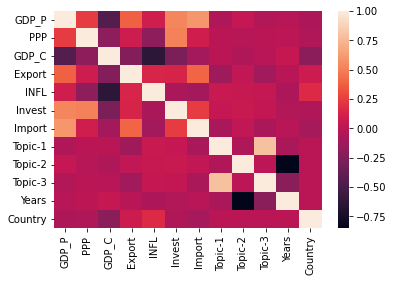

In [120]:
#Heatmap for VIF

sns.heatmap(X.corr())

In [121]:
vif=pd.DataFrame()
vif['Feature name']=X.columns
vif['VIF']=[variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])]

In [123]:
vif

,Feature name,VIF
0,GDP_P,40.187764
1,PPP,8.587614
2,GDP_C,10.785920
3,Export,19.266068
4,INFL,20.485877
5,Invest,19.561191
6,Import,22.322558
7,Topic-1,26.368950
8,Topic-2,2.488565
9,Topic-3,29.234702


In [124]:
#Removing columns having VIF greater than 30

vif_features=X.drop(['GDP_P'],axis=1)
vif_features.head()

,PPP,GDP_C,Export,INFL,Invest,Import,Topic-1,Topic-2,Topic-3,Years,Country
0,0.484629,0.000000,0.713780,0.528232,0.906003,0.711811,0.759653,0.684083,0.735581,1981,8
1,0.442493,0.700583,0.656211,0.425053,0.605126,0.583458,0.759653,0.684083,0.735581,1981,7
2,0.552329,0.429899,0.993281,0.556683,0.695917,0.721335,0.759653,0.684083,0.735581,1981,3
3,1.000000,0.603157,0.768193,0.184640,0.630691,0.577088,0.759653,0.684083,0.735581,1981,2
4,0.322401,0.240134,0.809750,0.771843,0.359646,0.932768,0.759653,0.684083,0.735581,1981,6


In [125]:
for i in range(len(X)):
  if vif_features['Years'][i]==2006:
    x_train=vif_features.iloc[:i,:]
    x_test=vif_features.iloc[i:,:]
    y_train=Y.iloc[:i,:]
    y_test=Y.iloc[i:,:]
    break

In [126]:
#Linear Regression with VIF

LR_ref=LinearRegression()
LR_ref.fit(x_train,y_train)
y_vif=LR_ref.predict(x_test)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, y_vif)

Test set evaluation:
_____________________________________
MAE: 0.04752948382728014
MSE: 0.00364210078951563
RMSE: 0.06034982012827901
R2 Square 0.9634428109566816


In [127]:
#Random Forest Regressor With VIF

RF=RandomForestRegressor()
RF.fit(x_train,y_train)
y_pred_rf_vif=RF.predict(x_test)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, y_pred_rf_vif)

Test set evaluation:
_____________________________________
MAE: 0.01311682360110906
MSE: 0.0005034048832200694
RMSE: 0.02243668610156298
R2 Square 0.9949471284446103


In [128]:
n_folds=5
param_grid = { 
            "n_estimators"      : [10,20,30.40,50],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8,12,16,18,20],
            "bootstrap": [True, False],
            }
grid = GridSearchCV(estimator=RF, param_grid=param_grid, n_jobs=-1, cv=n_folds)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8, 12, 16, 18, 20],
                         'n_estimators': [10, 20, 30.4, 50]})

In [129]:
grid.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 4,
 'n_estimators': 10}

In [130]:
grid_rf=RandomForestRegressor(bootstrap= True,
 max_features='auto',
 min_samples_split= 4,
 n_estimators= 10)
grid_rf.fit(x_train,y_train)

RandomForestRegressor(min_samples_split=4, n_estimators=10)

In [131]:
y_pred_grid_rf=grid_rf.predict(x_test)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, y_pred_grid_rf)

Test set evaluation:
_____________________________________
MAE: 0.011593338318042249
MSE: 0.000563380956917508
RMSE: 0.02373564738779012
R2 Square 0.994345125152844
